In [1]:
import pathlib

from heliostack import Image, ImageSequence
from heliostack.grid import compute_hull, compute_stack_rates

import torch
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import Angle
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

def median_reference_index(epochs):
    return np.where(epochs == np.percentile(epochs, 50, interpolation='nearest'))[0][0]


### Read in all of the images

In [2]:
def ingest_image(image_path, weight_path, device, dtype) -> Image:
    im = fits.open(image_path)
    wt = fits.open(weight_path)

    wcs = WCS(im[1].header)
    epoch = Time(im[1].header['MJD-OBS'], format='mjd', scale='utc')

    image = Image(im[1].data, 
                  wt[1].data, 
                  wcs, 
                  epoch, 
                  device=device,
                  dtype=dtype)
    return image

In [3]:
root = '/nfs/deep/diffim/B1a/20201018/CCD22'
#root = '/Users/kjnapier/Desktop/research/data/jts/B1a/20201018/CCD5/'

image_paths = list(pathlib.Path(root).glob('*.diff.rescale.bright.fits.fz'))[:5]
weight_paths = list(pathlib.Path(root).glob('*.diff.weight.bright.fits.fz'))[:5]
assert len(image_paths) == len(weight_paths)

# read in the images
images = []
for i, w in zip(image_paths, weight_paths):
    images.append(ingest_image(i, w, device, dtype))
sequence = ImageSequence(images)

### Calculate some metadata

In [4]:
reference_index = median_reference_index(sequence.epochs.numpy())
ra = Angle(sequence.images[reference_index].ra, u.rad)
dec = Angle(sequence.images[reference_index].dec, u.rad)
epoch = Time(sequence.epochs.numpy()[reference_index], format='jd', scale='utc')
duration = (sequence.epochs.max() - sequence.epochs.min()) * u.day

### Calculate the stack rates

In [5]:
hull = compute_hull(ra, dec, epoch, rmin=30, rmax=100, imin=0, imax=90)
ra_rates, dec_rates = compute_stack_rates(hull, 1, duration)

### Stack at each rate, and extract sources

In [6]:
import sep
import pandas as pd

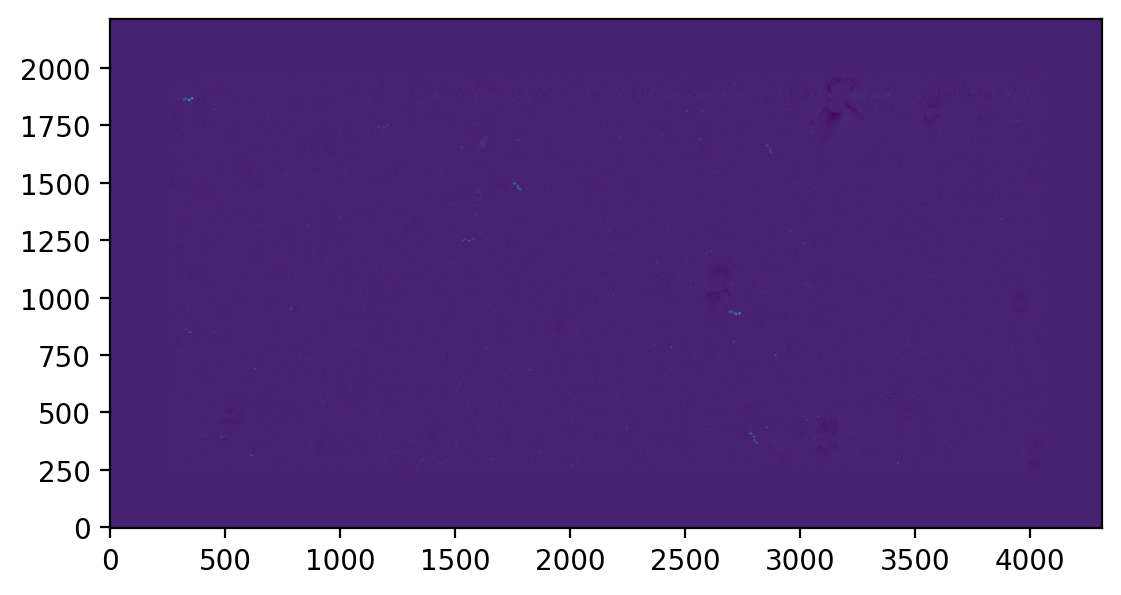

In [8]:
s, wcs = sequence.stack(-2, -1, reference_epoch=reference_index, EDGE_CUT_PIXELS=250, pixel_scale=0.27)
plt.imshow(s.cpu().numpy(), origin='lower')

In [7]:
catalog = []
for ra_rate, dec_rate in zip(ra_rates, dec_rates):
    s, wcs = sequence.stack(ra_rate, dec_rate, reference_epoch=reference_index, EDGE_CUT_PIXELS=250, pixel_scale=0.27)
    sources = sep.extract(np.float32(s.cpu().numpy()), 2, filter_type='matched')
    if len(sources) == 0:
        continue

    sources = pd.DataFrame(sources)

    # Can put in a neural net layer here

    # Add in the ra, dec, ra_rate, dec_rate
    sources['ra_rate'] = ra_rate
    sources['dec_rate'] = dec_rate
    ras, decs = wcs.all_pix2world(sources['x'], sources['y'], 0)
    sources['ra'] = ras
    sources['dec'] = decs

    # for source in sources.itertuples():
    #     fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    #     ax.imshow(s[int(source.y)-10:int(source.y)+10, int(source.x)-10:int(source.x)+10].cpu().numpy(), origin='lower')

    catalog.append(pd.DataFrame(sources))

catalog = pd.concat(catalog)

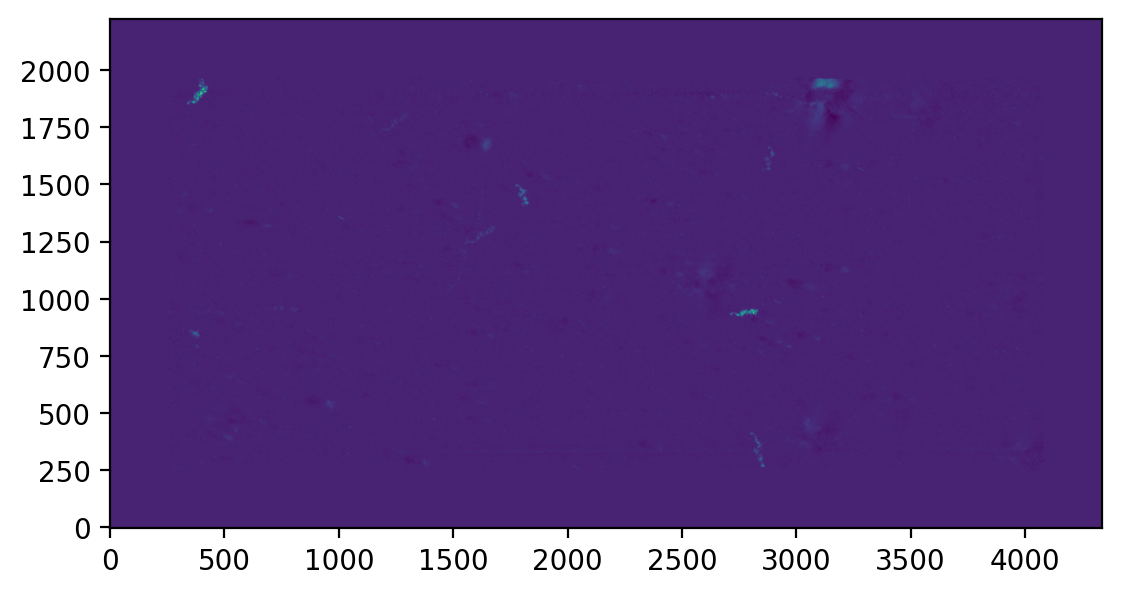

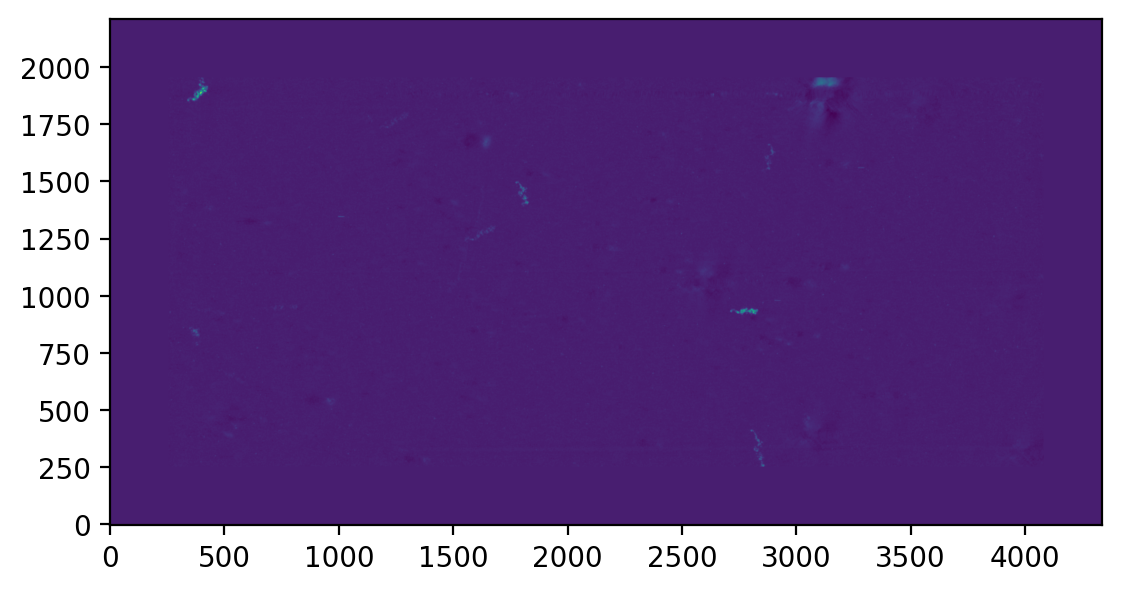

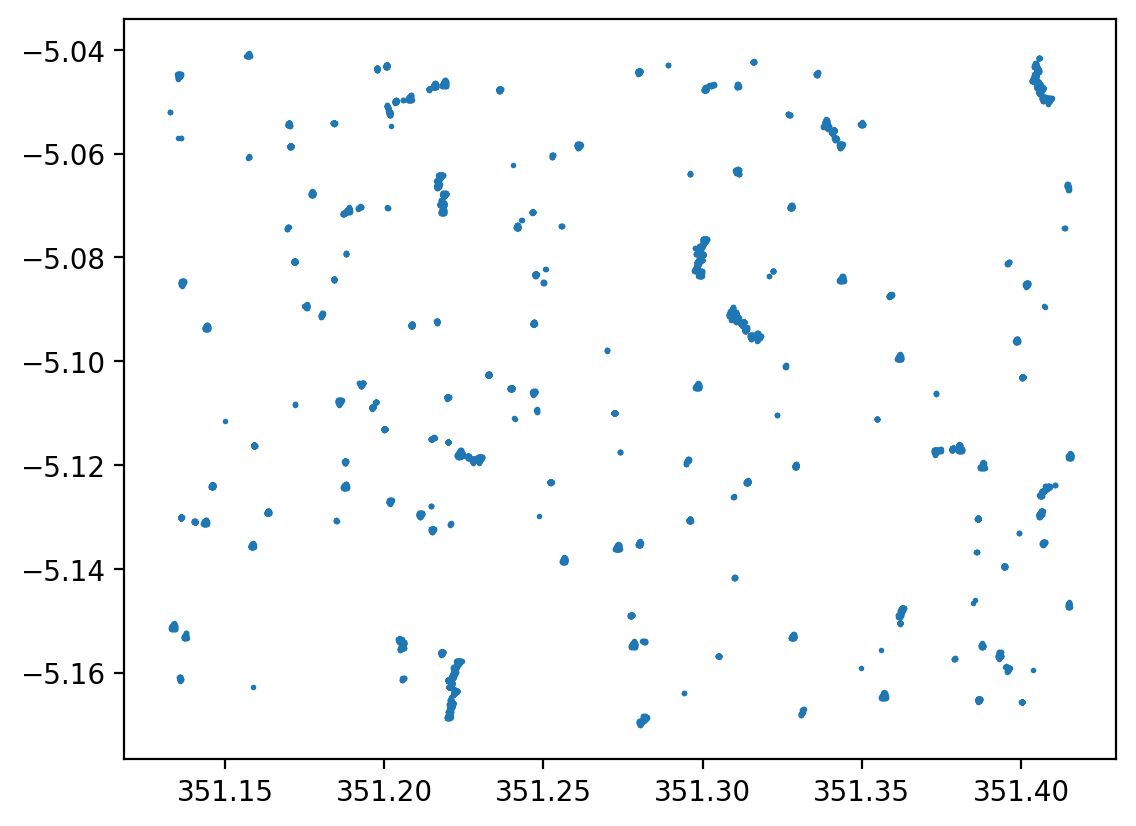

In [69]:
plt.scatter(catalog['ra'], catalog['dec'], s=1)

In [49]:
N = 3
M = int(np.ceil(len(xs) / N))
fig, ax = plt.subplots(M, N, figsize=(10, M * 1))
for idx, (x, y) in enumerate(zip(xs, ys)):
    
    x = int(x)
    y = int(y)
        
    #ax.imshow(s[y-25:y+26, x-25:x+26].cpu().numpy(), origin='lower')
    ax[idx // N, idx % N].imshow(s[y-25:y+26, x-25:x+26].cpu().numpy(), origin='lower')

for i in range(M):
    for j in range(N):
        ax[i, j].axis('off')

NameError: name 'xs' is not defined